<font size="8">Data analysis</font>

In the final NN model all the metrics are saved, including the target,prediction and the loss.  
This is used to calculate the statistics and create the graphs

<font size="5">Import the necessary packages</font>

In [1]:
import torch
import plotly.graph_objects as go
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score,
    precision_score, recall_score, f1_score, matthews_corrcoef
)

<font size="5">Import the model to analyse</font>

In [16]:
# Path
models_path = r"Y:\models_gijs"
# File name
model_embed = r"MLP_using_512_Linear_NoBias_One_hot_batch_16_epochs_150.pth"
#Load the model
model = torch.load(f"{models_path}/{model_embed}", map_location=torch.device("cpu"))
print(model.keys())
model_name = "OOD dataset 2, Gearnet 512 embedding followed by linear layer, dropout 0.5"
metrics = model["metrics"]
epochs = model["epoch"]

dict_keys(['model', 'epoch', 'batch_size', 'metrics'])


<font size="5">Retrieve all the individual metrics </font>

Calculate the accuracies

In [17]:
def reshape_and_stack(data):
    return torch.stack(data).detach().reshape(epochs, -1)

train_predict, train_target, train_loss = [reshape_and_stack(metrics["train"][key]) for key in ["predict", "targets", "losses"]]
val_predict, val_target, val_loss = [reshape_and_stack(metrics["val"][key]) for key in ["predict", "targets", "losses"]]

test_predict = torch.stack(metrics["test"]["predict"]).detach()
test_predict = test_predict.view(-1,test_predict.size(-1))
test_target = torch.stack(metrics["test"]["targets"]).detach()
test_target = test_target.view(-1,test_target.size(-1))

# Calculate the accuracy per epoch
def compute_accuracy(predictions, targets):
    predictions = (predictions >=0.5).float()
    return accuracy_score(targets.numpy(), predictions.numpy())

train_accuracies = torch.tensor([compute_accuracy(train_predict[epoch], train_target[epoch]) for epoch in range(epochs)])
val_accuracies = torch.tensor([compute_accuracy(val_predict[epoch], val_target[epoch]) for epoch in range(epochs)])

test_accuracies = compute_accuracy(test_predict, test_target)

print(f"Test accuracy: {test_accuracies}")

Test accuracy: 0.7181372549019608


In [13]:
print(val_predict[0,2])

tensor(0.4998)


<font size="5"> Plot the accuracies and losses per epoch</font>

In [18]:
fig = go.Figure().set_subplots(
    rows=1,
    cols=2,
    subplot_titles=("Mean accuracy", "Mean loss")
)

def add_trace(x, y, name, row, col):
    fig.add_trace(go.Scatter(x=x, y=y, name=name), row=row, col=col)

x = list(range(epochs))


add_trace(x, train_accuracies, "Train accuracy", 1, 1)
add_trace(x, val_accuracies, "Validation accuracy", 1, 1)
add_trace(x, train_loss.mean(axis=1), "Train loss", 1, 2)
add_trace(x, val_loss.mean(axis=1), "Validation loss", 1, 2)

fig.update_xaxes(title_text="Epoch")

fig.update_yaxes(title_text="Accuracy", row=1, col=1, range=[0.4, 1])
fig.update_yaxes(title_text="Binary Cross entropy loss", row=1, col=2, range=[0,1])


fig.update_layout(
    title_text= model_name,
    width=1800,
    font_size=13,
    height=700,\
    template="plotly"
)

fig.show()

<font size="5"> Calculate the remaining statistics </font>

Accuracy: 0.7181372549019608
Precision: 0.7335164835164835
Recall: 0.6675
F1-Score: 0.6989528795811517
MCC: 0.4367908207561218


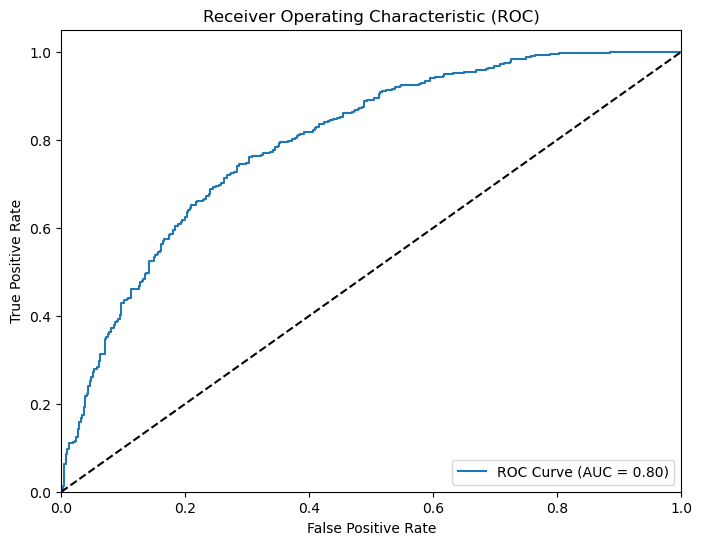

In [19]:
target = test_target.numpy()
predict = test_predict.numpy()
predict_binary = (predict >= 0.5).astype(np.int32)

# Calculate accuracy
accuracy = accuracy_score(target, predict_binary)

# Calculate precision
precision = precision_score(target, predict_binary)

# Calculate recall
recall = recall_score(target, predict_binary)

# Calculate F1-score
f1 = f1_score(target, predict_binary)

# Calculate ROC AUC
roc_auc = roc_auc_score(target, predict)


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(target, predict)

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(target, predict_binary)

# Print or use the metrics as needed
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"MCC: {mcc}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [40]:
from sklearn.metrics import matthews_corrcoef

def find_best_threshold(y_true, y_scores):
    thresholds = np.arange(0.1, 1.0, 0.01)  # Adjust the range as needed
    best_threshold = None
    best_mcc = -1
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        
        if mcc > best_mcc:
            best_mcc = mcc
            best_threshold = threshold
            
    return best_threshold, best_mcc

# Example usage:
# y_true = actual labels (0 or 1)
# y_scores = predicted scores (probability scores)

# Assuming you have your y_true and y_scores, you can call the function:
best_threshold, best_mcc = find_best_threshold(target, predict)

print(f"The best threshold is {best_threshold} with MCC of {best_mcc}")

The best threshold is 0.7199999999999996 with MCC of 0.15529849871464746


Comparing the different models based on ROC

In [2]:
import os
import numpy as np
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

path_model_OOD = [r"Y:\models_gijs\OOD2_models\MLP_using_OOD2_linear_without_bias_no_concat_batch_16_epochs_100.pth",
r"Y:\models_gijs\OOD2_models\MLP_using_OOD2_512_CNN_batch_16_epochs_100.pth",
r"Y:\models_gijs\OOD2_models\MLP_using_OOD2_512_Linear_dropout_0.2_batch_16_epochs_100.pth",
r"Y:\models_gijs\OOD2_models\MLP_using_OOD2_512_Linear_dropout_0.5_batch_16_epochs_100.pth",
r"Y:\models_gijs\OOD2_models\MLP_using_OOD2_CNN_batch_16_epochs_100.pth",
r"Y:\models_gijs\OOD2_models\MLP_using_OOD2_linear_batch_16_epochs_100.pth",
r"Y:\models_gijs\OOD2_models\MLP_using_OOD2_linear_without_bias_batch_16_epochs_100.pth",
r"Y:\models_gijs\OOD2_models\MLP_using_OOD_seq_based_2_batch_16_epochs_75.pth"]

name_OOD = ["512, Linear without bias",
        "512, Convolution",
        "512, Linear, dropout 0.2",
        "512, Linear, dropout 0.5",
        "3072, Convolution",
        "3072, Linear",
        "3072, Linear without bias",
        "One-hot encoding"]

name_OOD2 = ["MLP_Linear_NoBias_512",
             "MLP_Conv1D_512",
             "MLP_Linear_dropout_0.2_512",
             "MLP_Linear_dropout_0.5_512",
             "MLP_Conv1D_3072",
             "MLP_Linear_3072", # Is not correct
             "MLP_Linear_NoBias_3072",
             "MLP_OneHot_Encoding"]

path_model = [r"Y:\models_gijs/Shuffled_model/MLP_using_Linear_no_bias_no_concat_batch_16_epochs_75.pth",
r"Y:\models_gijs/Shuffled_model/MLP_using_CNN_no_concat_batch_16_epochs_75.pth",
r"Y:\models_gijs/Shuffled_model/MLP_using_Linear_no_concat_batch_16_epochs_75.pth",
r"Y:\models_gijs/Shuffled_model/MLP_using_CNN_no_dropout_batch_16_epochs_75.pth",
r"Y:\models_gijs/Shuffled_model/MLP_using_Linear_batch_16_epochs_75.pth",
r"Y:\models_gijs/Shuffled_model/MLP_using_Linear_no_bias_batch_16_epochs_75.pth",
r"Y:\models_gijs/Shuffled_model/MLP_using_seq_based_batch_16_epochs_75.pth"]

name = ["512, Linear without bias",
        "512, Convolution",
        "512, Linear, dropout 0.5",
        "3072, Convolution, no dropout",
        "3072, Linear",
        "3072, Linear without bias",
        "One-hot encoding"]

name2 = ["MLP_Linear_NoBias_512",
         "MLP_Conv1D_512",
         "MLP_Linear_dropout_0.5_512", #Is not correct
         "MLP_Conv1D_3072",
         "MLP_Linear_3072",
         "MLP_Linear_NoBias_3072",
         "MLP_OneHot_Encoding"]

Creating the plot

In [3]:
# Initialize an empty figure
# Load the model
fig = go.Figure()

# Define a function to reshape and stack the given data
def reshape_and_stack(data):
    return torch.stack(data).detach().reshape(epochs, -1)

# Loop through models and add ROC curves to the figure
for path, model_name in zip(path_model, name_OOD2):
    try:
        # Load the model
        load_model = torch.load(path, map_location=torch.device("cpu"))
        metrics = load_model["metrics"]
        epochs = load_model["epoch"]

    except FileNotFoundError:
        print(f"File not found: {path}")
    except Exception as e:
        print(f"An error occurred while loading {path}: {e}")

    # Reshape and stack training and validation metrics
    train_predict, train_target, train_loss = [reshape_and_stack(metrics["train"][key]) for key in ["predict", "targets", "losses"]]
    val_predict, val_target, val_loss = [reshape_and_stack(metrics["val"][key]) for key in ["predict", "targets", "losses"]]

    # Reshape and stack test predictions and targets
    test_predict = torch.stack(metrics["test"]["predict"]).detach()
    test_predict = test_predict.view(-1, test_predict.size(-1))
    test_target = torch.stack(metrics["test"]["targets"]).detach()
    test_target = test_target.view(-1, test_target.size(-1))

    target = test_target.numpy()
    predict = test_predict.numpy()

    # Calculate ROC curve (fpr, tpr) and AUC
    fpr, tpr, _ = roc_curve(target, predict)  # y_true are the true labels
    roc_auc = auc(fpr, tpr)

    # Add a Scatter plot for the current model to the figure
    fig.add_trace(go.Scatter(x=fpr, y=tpr,
                             mode='lines',
                             name=f'{model_name} (AUC={roc_auc:.2f})'))

# Customize the layout of the figure
fig.update_layout(title='ROC Curve for out of distribution dataset',
                  xaxis=dict(title='False Positive Rate'),
                  yaxis=dict(title='True Positive Rate'),
                  legend=dict(x=0.7, y=0.2),
                  width=800,
                  height=600,
                  font_size=13,
                  template="plotly")

# Add a dashed line to represent the diagonal (random) ROC curve
fig.add_shape(
    type='line', line=dict(dash='dash', color='gray', width=2),
    x0=0, x1=1, y0=0, y1=1
)

# Update the layout with additional settings
fig.update_layout(title=dict(text='ROC Curve LOOCV, One-Hot Encoding',
                            x=0.5),
                  xaxis=dict(title='False Positive Rate',
                             linecolor='black',
                             linewidth=2,
                             tickformat=".1f"),
                  yaxis=dict(title='True Positive Rate',
                             linecolor='black',
                             linewidth=2,
                             tickformat=".1f"),
                  legend=dict(x=0.55, y=0.02,
                              bordercolor='black',
                              font=dict(
                                  size=12,
                                  color="black")),
                  width=600,
                  height=600,
                  font_size=13,
                  showlegend=True,
                  template='plotly',
                  legend_bordercolor="black"
)

# Update the x-axis and y-axis ranges
fig.update_xaxes(
    range=[-0.05, 1.05]  # Set the range of the x-axis
)
fig.update_yaxes(
    range=[-0.05, 1.05]  # Set the range of the y-axis
)

# Show the plot
fig.show()

Change the layout of the figure


In [4]:
fig.update_layout(title=dict(text='ROC Curve LOOCV, One-Hot Encoding', 
                            x=0.5), 
                  xaxis=dict(title='False Positive Rate',
                             linecolor='black', 
                             linewidth=2,
                             tickformat=".1f"),
                  yaxis=dict(title='True Positive Rate',
                             linecolor='black', 
                             linewidth=2,
                             tickformat=".1f"),
                  legend=dict(x=0.4, y=0.02,
                                bordercolor='black',
                              font=dict(
                                  size=12,
                                  color="black")),
                  width = 600,
                  height = 600,
                  font_size=13,
                  showlegend=True,
                  template='plotly',
                  legend_bordercolor="black"
)

fig.update_xaxes(
    range=[-0.05, 1.05]  # Set the range of the x-axis (from 2 to 3)
)
fig.update_yaxes(
    range=[-0.05, 1.05]  # Set the range of the x-axis (from 2 to 3)
)

fig.show()